Supervised Machine Learning Challenge I: Predict Quantitative Monitor Parameters

Now that we know how to load a visualize data ([LearningFromSpec_part1](LearningFromSpec_part1.ipynb))
And how to select wavelengths within spectra ([LearningFromSpec_part2](LearningFromSpec_part2.ipynb))
This script demonstrates a workflow for predicting key monitoring parameters
using supervised machine learning:

    A) Violaxanthin (ppm)
    B) Concentration (million cells/mL)
    C) Single-cell cytometric parameters (CytoNR and CytoFSC, a.u.)

The workflow includes:
    - Data loading and preprocessing
    - Defining input and output variables
    - Dataset splitting (training vs. testing)
    - Visualization of outputs by assay and split

In [1]:
# 1. Import Libraries and Load Data

import pandas as pd

folder = 'NO Dataset'

# Load datasets from pickle files
monitordata = pd.read_pickle(folder + '/monitordata.pkl')
fluorodata = pd.read_pickle(folder + '/fluorodata.pkl')
absdata = pd.read_pickle(folder + '/absdata.pkl')

#---------------------------------------------------------------------------
# Identify index columns (metadata, sample information)
IDCOLUMNS_COUNT = 14
sampleinfo = list(monitordata.columns[:IDCOLUMNS_COUNT])

# Collect names for outputs (monitoring vars) and inputs (spectral data)
monitor_vars = list(monitordata.columns[IDCOLUMNS_COUNT:])   # e.g., Vx, CC, CytoNR...
abswaves = list(absdata.columns[IDCOLUMNS_COUNT:])
fluorowaves = list(fluorodata.columns[IDCOLUMNS_COUNT:])

# Set sample info columns as multi-index for all datasets
monitordata = monitordata.set_index(sampleinfo)
absdata = absdata.set_index(sampleinfo)
fluorodata = fluorodata.set_index(sampleinfo)

Splitting the dataset is essential for evaluating model generalization and preventing overfitting.
Models are trained on the training set and validated on the test set, simulating unseen data.

At the end, we add labels '1 - Training' and '2 - Test', so we may distinguish datapoint according to the data split

In [8]:
# 2. Dataset Splitting: Training and Testing Sets

# Choose split criteria and target variable
split_on = 'Batch_ID'  # Metadata column to split by (e.g., batch, experiment, etc.)
split_method = ['NOAx2_01', 'NOAx2_10', 'NOAx3_01',
                'NOAx4_01', 'NOAx4_08', 'NOAx4_11'] #'Random'  # Options: 'Random' (default), or provide batch list for custom split
test_size = 1/5   # Proportion of batches for testing

# Choose spectroscopy type and output variable to predict
spectroscopy = '2DF'           # Options: '2DF' (fluorescence), 'Abs' (absorption)
output2predict = 'Vx (ppm)'    # Example: 'Vx (ppm)', 'CC (million cells/mL)', etc.

# Select input data
if spectroscopy == '2DF':
    input_df = fluorodata.copy()
    input_features = fluorowaves
elif spectroscopy == 'Abs':
    input_df = absdata.copy()
    input_features = abswaves
else:
    raise ValueError("Invalid spectroscopy type. Choose '2DF' or 'Abs'.")

# Join output variable to the input DataFrame
input_df = input_df.join(monitordata[[output2predict]])

# Get unique batches for split
unique_batches = input_df.index.get_level_values(split_on).unique()

# Perform the split (random or custom)
if split_method == 'Random':
    from sklearn.model_selection import train_test_split
    train_batches, test_batches = train_test_split(
        unique_batches, test_size=test_size, random_state=2
    )
else:
    # User-provided split (define train/test batch lists)
    train_batches = [b for b in unique_batches if b not in split_method]
    test_batches = [b for b in unique_batches if b in split_method]

print("Training Set Batches:", list(train_batches))
print("Testing Set Batches:", list(test_batches))

# Annotate rows with 'Split' label
input_df['Split'] = '1 - Training'
input_df.loc[
    input_df.index.get_level_values(split_on).isin(test_batches), 'Split'
] = '2 - Test'


# Reset and set new index for easy selection
input_df = input_df.reset_index().set_index(sampleinfo + ['Split']).dropna()

Training Set Batches: ['NOAx2_02', 'NOAx2_03', 'NOAx2_04', 'NOAx2_05', 'NOAx2_06', 'NOAx2_07', 'NOAx2_08', 'NOAx2_09', 'NOAx2_11', 'NOAx2_12', 'NOAx3_02', 'NOAx3_03', 'NOAx3_04', 'NOAx3_05', 'NOAx4_02', 'NOAx4_03', 'NOAx4_04', 'NOAx4_05', 'NOAx4_06', 'NOAx4_07', 'NOAx4_09', 'NOAx4_10', 'NOAx4_12']
Testing Set Batches: ['NOAx2_01', 'NOAx2_10', 'NOAx3_01', 'NOAx4_01', 'NOAx4_08', 'NOAx4_11']


Declare inputs as X and output as y

In [9]:
# 3. Prepare Input (X) and Output (y) Matrices

# Output (target vector)
y = input_df[[output2predict]]

# Input (feature matrix)
X = input_df[input_features]

# Split into train and test sets
X_train = X[X.index.get_level_values('Split') == '1 - Training']
y_train = y[y.index.get_level_values('Split') == '1 - Training']
X_test = X[X.index.get_level_values('Split') == '2 - Test']
y_test = y[y.index.get_level_values('Split') == '2 - Test']

Is the test split significantly different than the training set?

Here we use plots to check for that

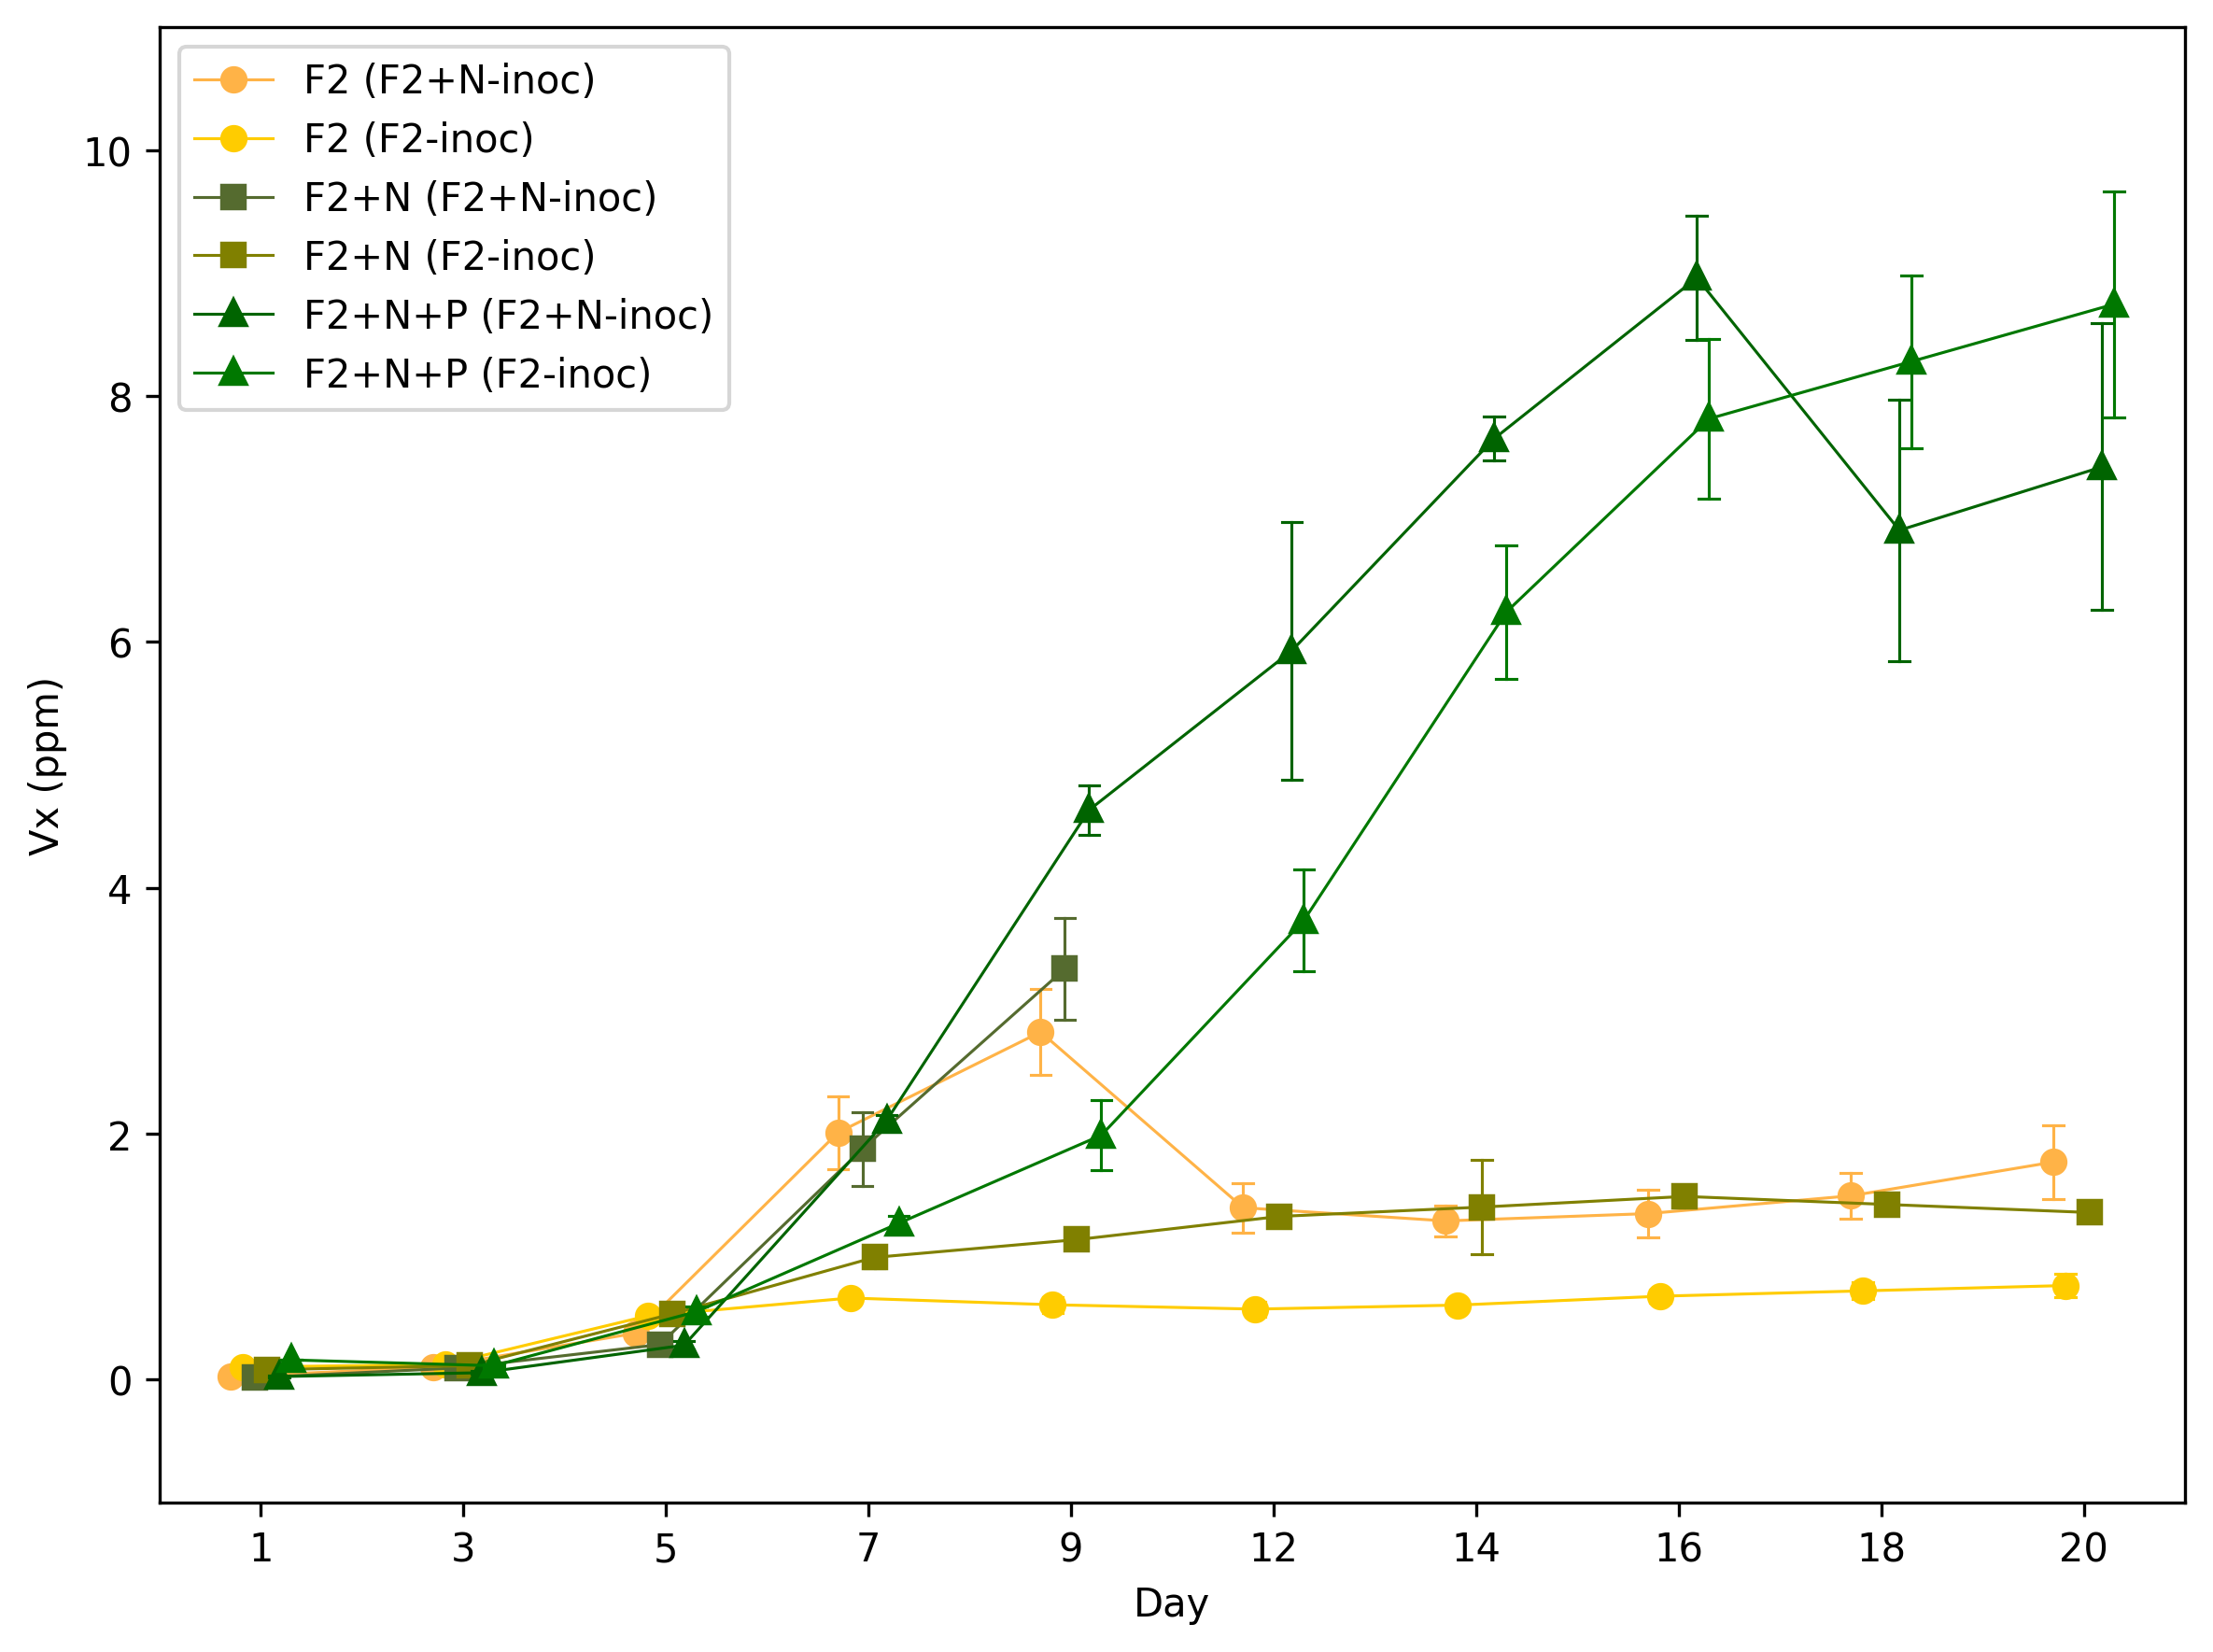

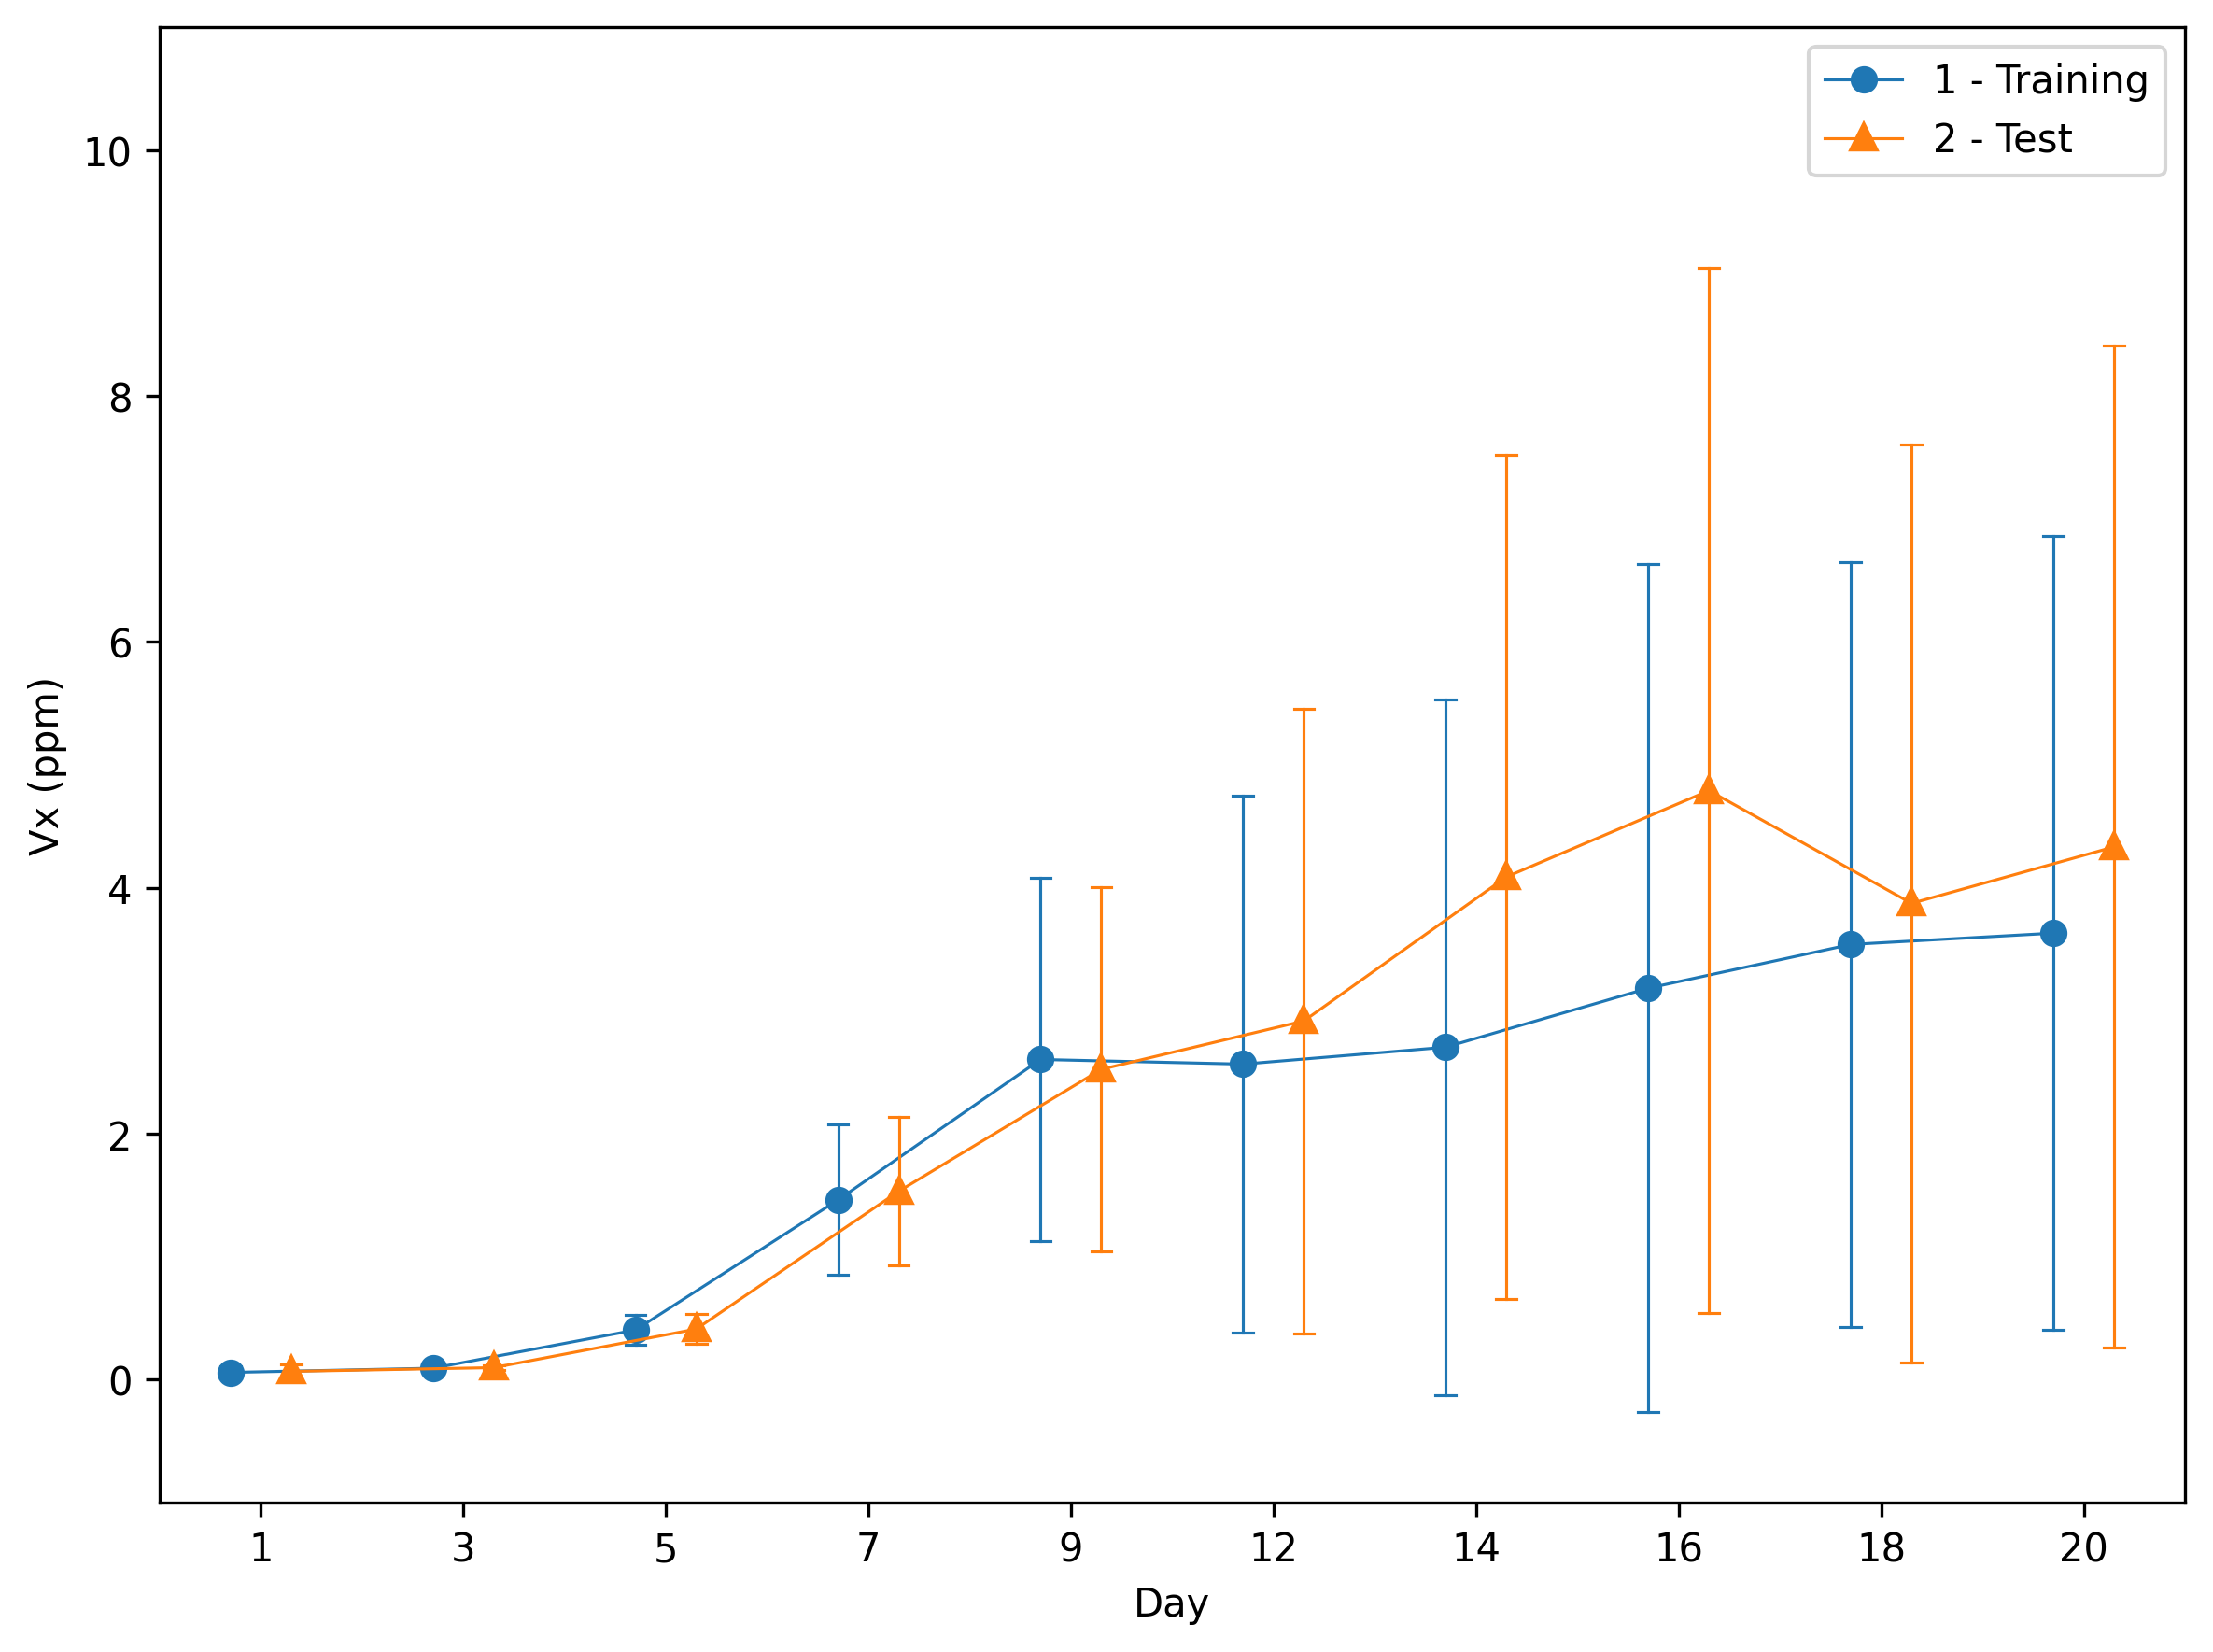

In [10]:
# 4. Visualization: Output Variable by Assay and Split

from output_plotter import plot_output_timewise

# Color palette for plotting (customize as needed)
colors = [
    (255, 179, 71),   # Yellowish Orange
    (255, 204, 0),    # Yellow-Orange
    (85, 107, 47),    # Dark Olive Green
    (128, 128, 0),    # Olive Green
    (0, 100, 0),      # Dark Green
    (0, 120, 0),      # Forest Green
]
markers = ['o', 'o', 's', 's', '^', '^']

# Plot output variable by Assay
plot_output_timewise(
    y, 'Day', output2predict, 'Assay',
    figsize=(8, 6),
    lighten_factor=0.2,
    colors=colors,
    justpoint=True,
    index=True,
    legend=1,
    symbols=markers,
    ylim=[-1, 11]
)

# Plot output variable by dataset Split (Train/Test)
plot_output_timewise(
    y, 'Day', output2predict, 'Split',
    figsize=(8, 6),
    lighten_factor=0.2,
    colors=['C0', 'C1'],
    justpoint=True,
    index=True,
    legend=1,
    symbols=['o','^'],
    ylim=[-1, 11]
)



On this last graph, we may see that the means and standard deviations from each split are not significantly different.

Nest, we will define and visualize a pipeline for predictive modelling.

Rather than simply fitting a regression algorithm to the data, we use 
scikit-learn's Pipeline structure to chain together a sequence of data 
transformations followed by a predictive model. This modular approach is
valuable in spectroscopy and similar domains, where raw data often contains 
noise, artifacts, or irrelevant information.

In this case, pipeline steps will include:
    - Variable (wavelength) selection
    - Pre-processing transformations (e.g., SNV, log-shift)
    - Dimensionality reduction (e.g., PCA)
    - Regression or classification algorithm
    - Algorithm's architecture, a.k.a. hyperparameters

By encapsulating these steps, the pipeline helps ensure robust, reproducible,
and interpretable model development.

In [7]:
# 5. Definition of a Pipeline for Predictive Modelling

# Import scikit-learn's Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Import pipeline transformation steps
from variable_selection import waveRestrictor2          
from sklearn.preprocessing import StandardScaler      
from sklearn.decomposition import PCA                    

# Import regression algorithms

from sklearn import svm, set_config

# ======================================================================== #
# Example: Define and visualize a modelling pipeline

pipeline = Pipeline([
    # Step 1: Wavelength selection (Moving-window)
    ('Wave-selection', waveRestrictor2(name='Moving-Window')),

    # Step 2: Pre-processing transformations  (standar normal variation + PCA)
    ('Pre-process', make_pipeline(StandardScaler(),PCA(n_components=2))),

    # Step 3: Regression algorithm (Support Vector Regression)
    ('Algorithm', svm.SVR(C=10)),
    

])

# To further inspect pipeline configuration:
set_config(display='diagram')
pipeline


Pipeline(steps=[('Wave-selection', waveRestrictor2(name='Moving-Window')),
                ('Pre-process',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('Algorithm', SVR(C=10))])

Training

We want to find the pipeline that best produces a model. However, we have
to be careful with overfitting: complex models will be able to memorize the
dataset, including noise and outliers.

In this section, we will use an overfitting-proof search algorithm called 
'RandomizedSearchCV' to find the optimal pipeline.

It is called 'Randomized' because it randomly generates pipeline configurations
by sampling values for each step from predefined lists or intervals.

'SearchCV' refers to the fact that it searches for the pipeline with the best
performance under Cross-Validation (CV).
    
In cross-validation, the pipeline is repeatedly used to fit and test models
across different splits of the training data. Each test is called a 'validation',
and in the end, we obtain a measure of the pipeline's robustness.
    
If a pipeline produces models that memorizes the data, cross-validation
performance will necessarily be lower, because the model's ability to 
generalize was compromised.



In [30]:
# Import spectral variable selections
from variable_selection import add_windows, waveRestrictor2, EEM_squaredwindowgenerator, fluoro1Dgen

# Spectral variable selections
# Define dictionaries of 2 random windows of size 20 and all spectrum
w2 = EEM_squaredwindowgenerator(size=20, overlap=0.1, numberofwindows=2, 
                                desired_length=100)
w1 = EEM_squaredwindowgenerator(size=10, overlap=0.1, numberofwindows=1, 
                                desired_length=1000)

counter, windows = add_windows(w1, "MW1_", counter = {}, window_dict= {})

# wLeds = fluoro1Dgen(fluorowaves,
#                     window_size=3,
#                     selected_excitations=[470,530,650]
                                   # )
# counter, windows = add_windows(wLeds, "Leds_",counter = counter, window_dict= windows)

add_windows([fluorowaves], "All_", counter = counter, window_dict= windows)

# Import pre-process transformations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformations import LogShift

# Import regression algorithms
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

# Import performance metrics
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from accuracy import rmse


# Define placeholder pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from scipy.stats import loguniform,uniform



pipeline = Pipeline([
    ('Wave-selection', waveRestrictor2(name='Moving-Window', window_dict=windows)),
    ('Pre-process', StandardScaler()),
    ('Algorithm', SVR(C=10)),
])

import numpy as np

search_spaces = [

    # SVR search space
    {
        'Wave-selection__window': ['All_1'],
        'Pre-process': [
            StandardScaler(),
            # Optionally add more, e.g. make_pipeline(StandardScaler(), PCA(n_components=3)),
        ],
        'Algorithm': [SVR()],
        'Algorithm__kernel': ['rbf'],
        'Algorithm__C': loguniform(1e-4, 1e4),
        'Algorithm__epsilon': loguniform(1e-4, 1e3),
        # 'Algorithm__gamma': loguniform(1e-6, 1e-1)
    },

]



# Define leave-K folds method for cross-validation: Leave-one-assay-out CV

crossval_foldby = 'Assay'
groups = X_train.index.get_level_values(crossval_foldby)
folds = list(groups.unique())
group_kfold = GroupKFold(n_splits=len(folds))

# Define cross-validation performance metrics: mean squared error
from sklearn.metrics import make_scorer,mean_squared_error
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)

# Define search method, in this case we choose 1000 random pipelines
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
n_iter = 100


search = RandomizedSearchCV(pipeline, search_spaces, n_iter = n_iter,
                            scoring = mse_scorer,  
                            cv = group_kfold,
                            verbose=1)  

 

search.fit(X_train, y_train.values.ravel(), groups=groups)
best_pipe = search.best_estimator_

print("The best pipeline is: ")
set_config(display='diagram')
best_pipe

Fitting 6 folds for each of 100 candidates, totalling 600 fits
The best pipeline is: 


Pipeline(steps=[('Wave-selection',
                 waveRestrictor2(name='Moving-Window', window='All_1', window_dict={'All_1': ['EEP 250 / 260 nm', 'EEP 250 / 265 nm', 'EEP 250 / 270 nm', 'EEP 250 / 275 nm', 'EEP 250 / 280 nm', 'EEP 250 / 285 nm', 'EEP 250 / 290 nm', 'EEP 250 / 295 nm', 'EEP 250 / 300 nm', 'EEP 250 / 305 nm', 'EEP 250 / 310 nm', 'EEP 250 / 315 nm', 'EEP 250 / 320 nm', 'EEP 250 / 325 nm', 'EEP 250 / 330 nm', 'EEP 250 / 335 nm', 'E...660 nm', 'EEP 280 / 660 nm', 'EEP 285 / 660 nm', 'EEP 290 / 660 nm', 'EEP 295 / 660 nm', 'EEP 250 / 665 nm', 'EEP 255 / 665 nm', 'EEP 260 / 665 nm', 'EEP 265 / 665 nm', 'EEP 270 / 665 nm', 'EEP 275 / 665 nm', 'EEP 280 / 665 nm', 'EEP 285 / 665 nm', 'EEP 290 / 665 nm', 'EEP 295 / 665 nm']})),
                ('Pre-process', StandardScaler()),
                ('Algorithm',
                 SVR(C=np.float64(1.8976305196723557),
                     epsilon=np.float64(0.00035633356650064757)))])

Here we see the main results for our best pipeline: we may see the best
spectral selection, and two accuracy plots: the training (pipeline fitting
model to the entire training set) and the cross-validation (pipeline leave-one-
-assay-out cross-validation)

C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best cross-validation Q2: 0.813
Best cross-validation rmse: Vx (ppm)    1.047
dtype: float64


C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: D

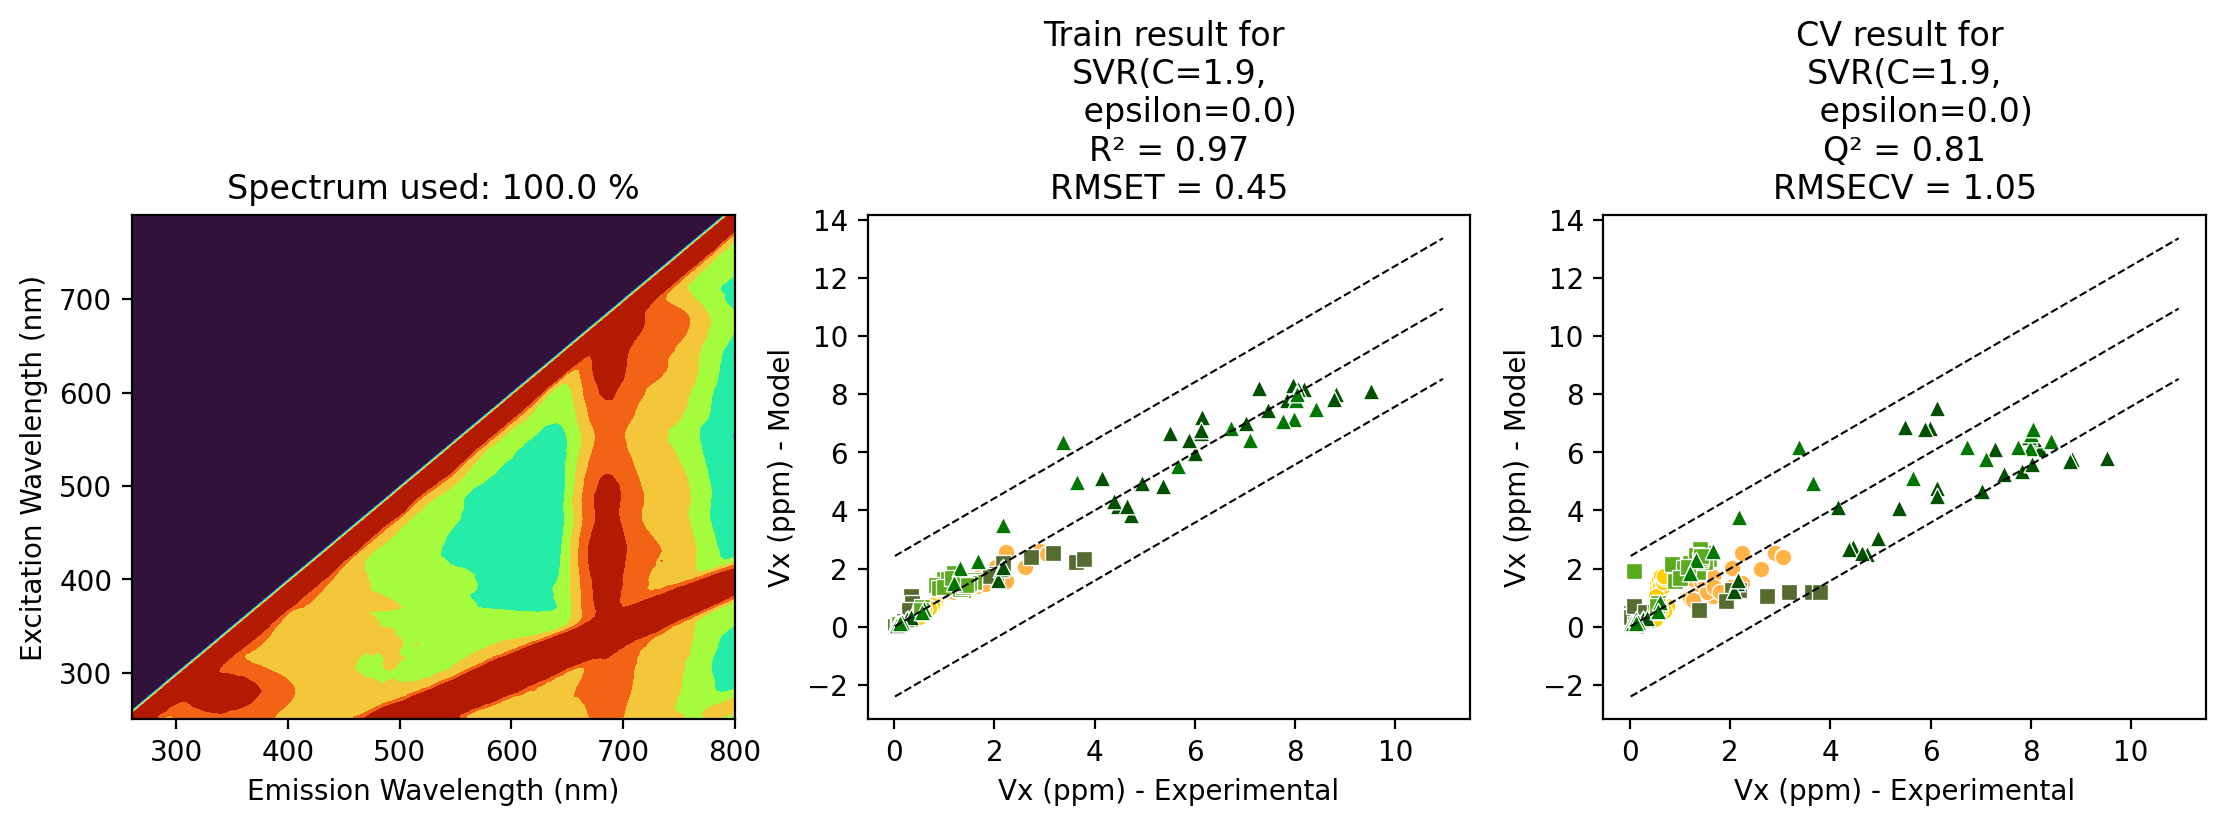

In [31]:
#%% - Plot results for Winner Pipeline

import numpy as np

# Choose colors and markers for accuracy plots

colors = [
    (255, 179, 71),   # Yellowish Orange
    (255, 204, 0),      # Yellow-Orange
    (85, 107, 47),    # Dark Olive Green (Brownish Green)
    (90, 170, 30),    # Olive Green
    (0, 80, 0),      # Dark Green
    (0, 120, 0),      # Forest Green
]

markers = ['o','o','s','s','^','^']

# Sample whose spectra is used for showing for spectral variable selection
sample2plot = 'NOAx2_03_20'

from special_plots import plot_bestmodel2
from accuracy import r2,rmse,r2_score,plotAccScatters_justtest
from accuracy import cross_val_predict


sampledata = y_train.reset_index().iloc[:,:IDCOLUMNS_COUNT]
y_predtrainCV = cross_val_predict(best_pipe, X_train, y_train.values.ravel(), 
                                  cv=group_kfold,
                                  groups=groups
                                  )
  
rmseCV = rmse(y_train, y_predtrainCV)
q2 = r2_score(y_train, y_predtrainCV)
print("Best cross-validation Q2:", np.round(q2,3))
print("Best cross-validation rmse:", np.round(rmseCV,3))


y_predtrainCV = pd.DataFrame(data=y_predtrainCV,
                             index=y_train.index,
                             columns=[output2predict+' - Model'])


plot_bestmodel2(best_pipe,X_train.copy() ,y_train,group_kfold,groups,
                   sample2plot,output2predict,sampledata,spectroscopy,'Assay',
                   markers=markers, colors=colors,rgb_colors=True,
                   # randomCVfold=6
                   )

Random search allows us to not waste too much computational time
on useless/overfitting pipelines

However, since we will not cover every possible combination of
pipeline steps, we need a map to guide us closer to the best

C:\Users\pedro.brandao\AppData\Local\Temp\ipykernel_29420\3437585442.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stdy = float(y_train.std())
C:\Users\pedro.brandao\Documents\Python env\LearningFromSpectra\gridsearch_plots.py:122: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  std_val = float(y_train.std())


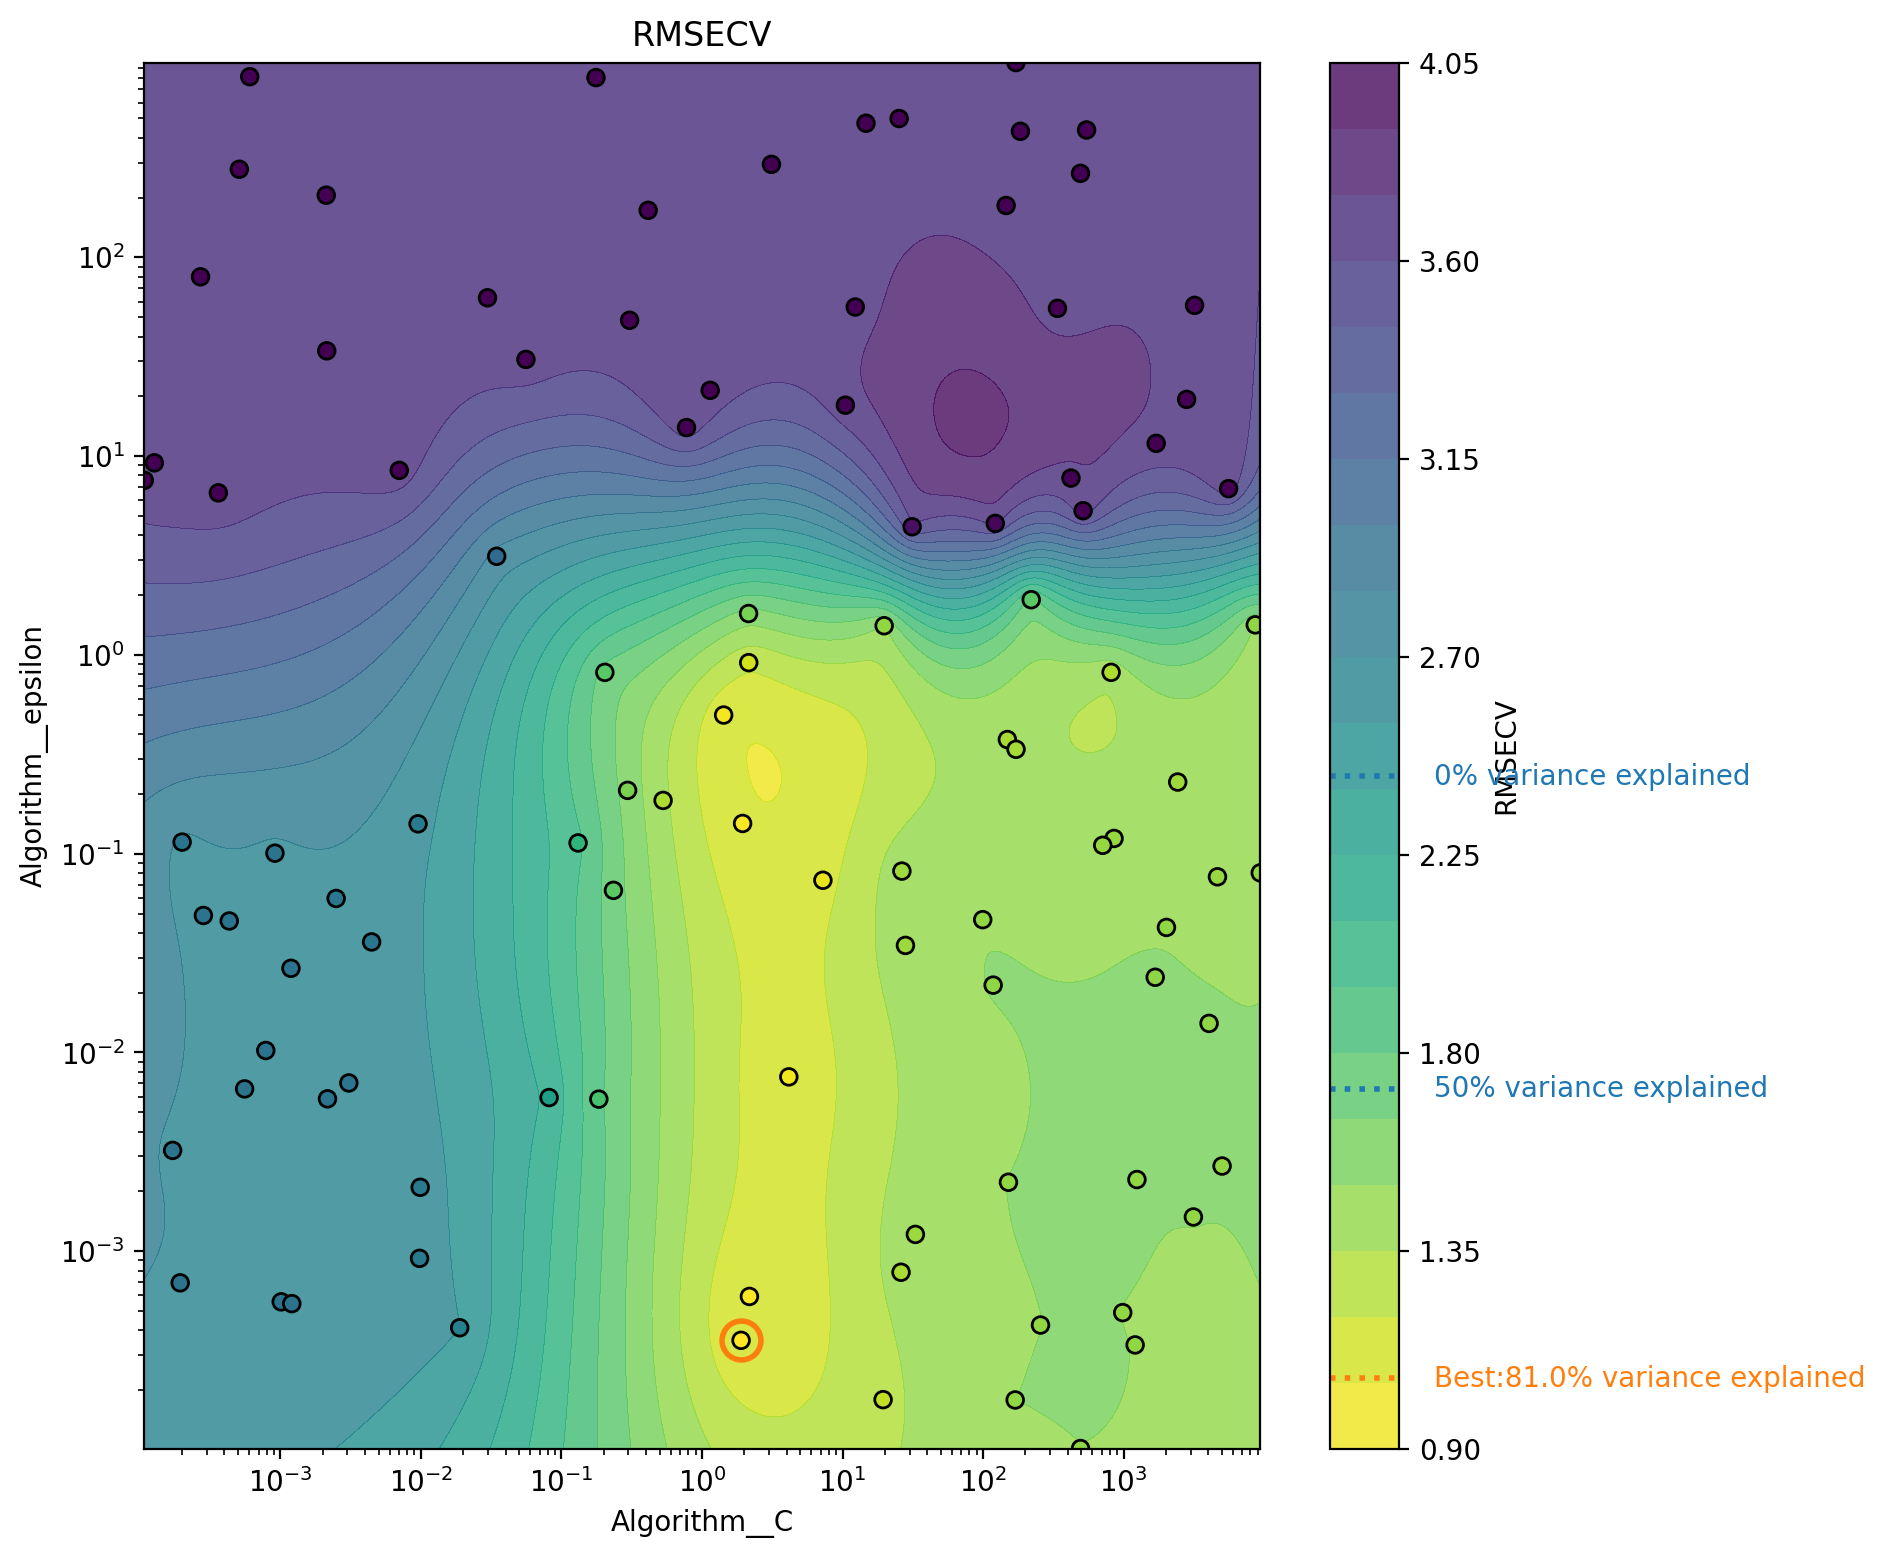

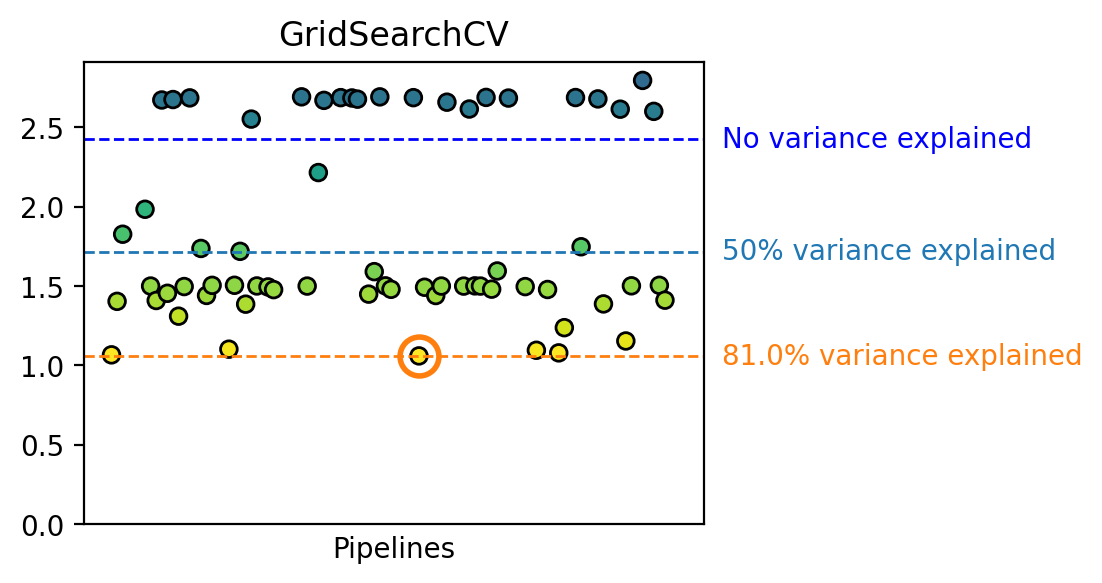

In [32]:
#%% Plots for a global visualization of the search

from gridsearch_plots import plot_rmsecv_barplot,plot_hyperparam_contour

stdy = float(y_train.std())

plot_hyperparam_contour(
    search,
    y_train,
    'Algorithm__C',
    'Algorithm__epsilon',
    # 'Algorithm__gamma',

)
plot_rmsecv_barplot(search, stdy)

We found the optimal pipeline by tweaking hyperparameters C and epsilon

However, SVR has another hyperparameter: gamma. So we can further tune our pipeline

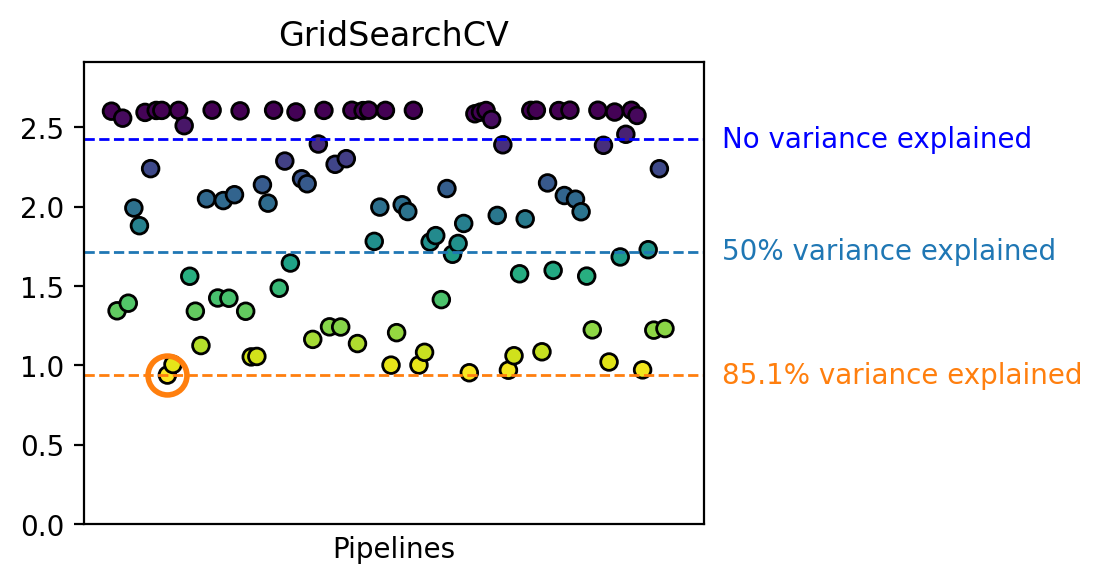

In [33]:
# Tweak hyperparameter 'gamma'


search_spaces = [

    # SVR search space
    {
        'Wave-selection__window': ['All_1'],
        'Pre-process': [
            StandardScaler(),
            # Optionally add more, e.g. make_pipeline(StandardScaler(), PCA(n_components=3)),
        ],
        'Algorithm': [SVR()],
        'Algorithm__kernel': ['rbf'],
        'Algorithm__C': [1.295],
        'Algorithm__epsilon': [0.0000997],
        'Algorithm__gamma': loguniform(1e-6, 1e0),
        
    }
]

n_iter = 100

search = RandomizedSearchCV(pipeline, search_spaces, n_iter = n_iter,
                            scoring = mse_scorer,  
                            cv = group_kfold,
)  

search.fit(X_train, y_train.values.ravel(), groups=groups)
best_pipe2 = search.best_estimator_

plot_rmsecv_barplot(search, stdy)

C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best cross-validation Q2: 0.813
Best cross-validation rmse: Vx (ppm)    1.047
dtype: float64


C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\sklearn\utils\validation.py:1406: D

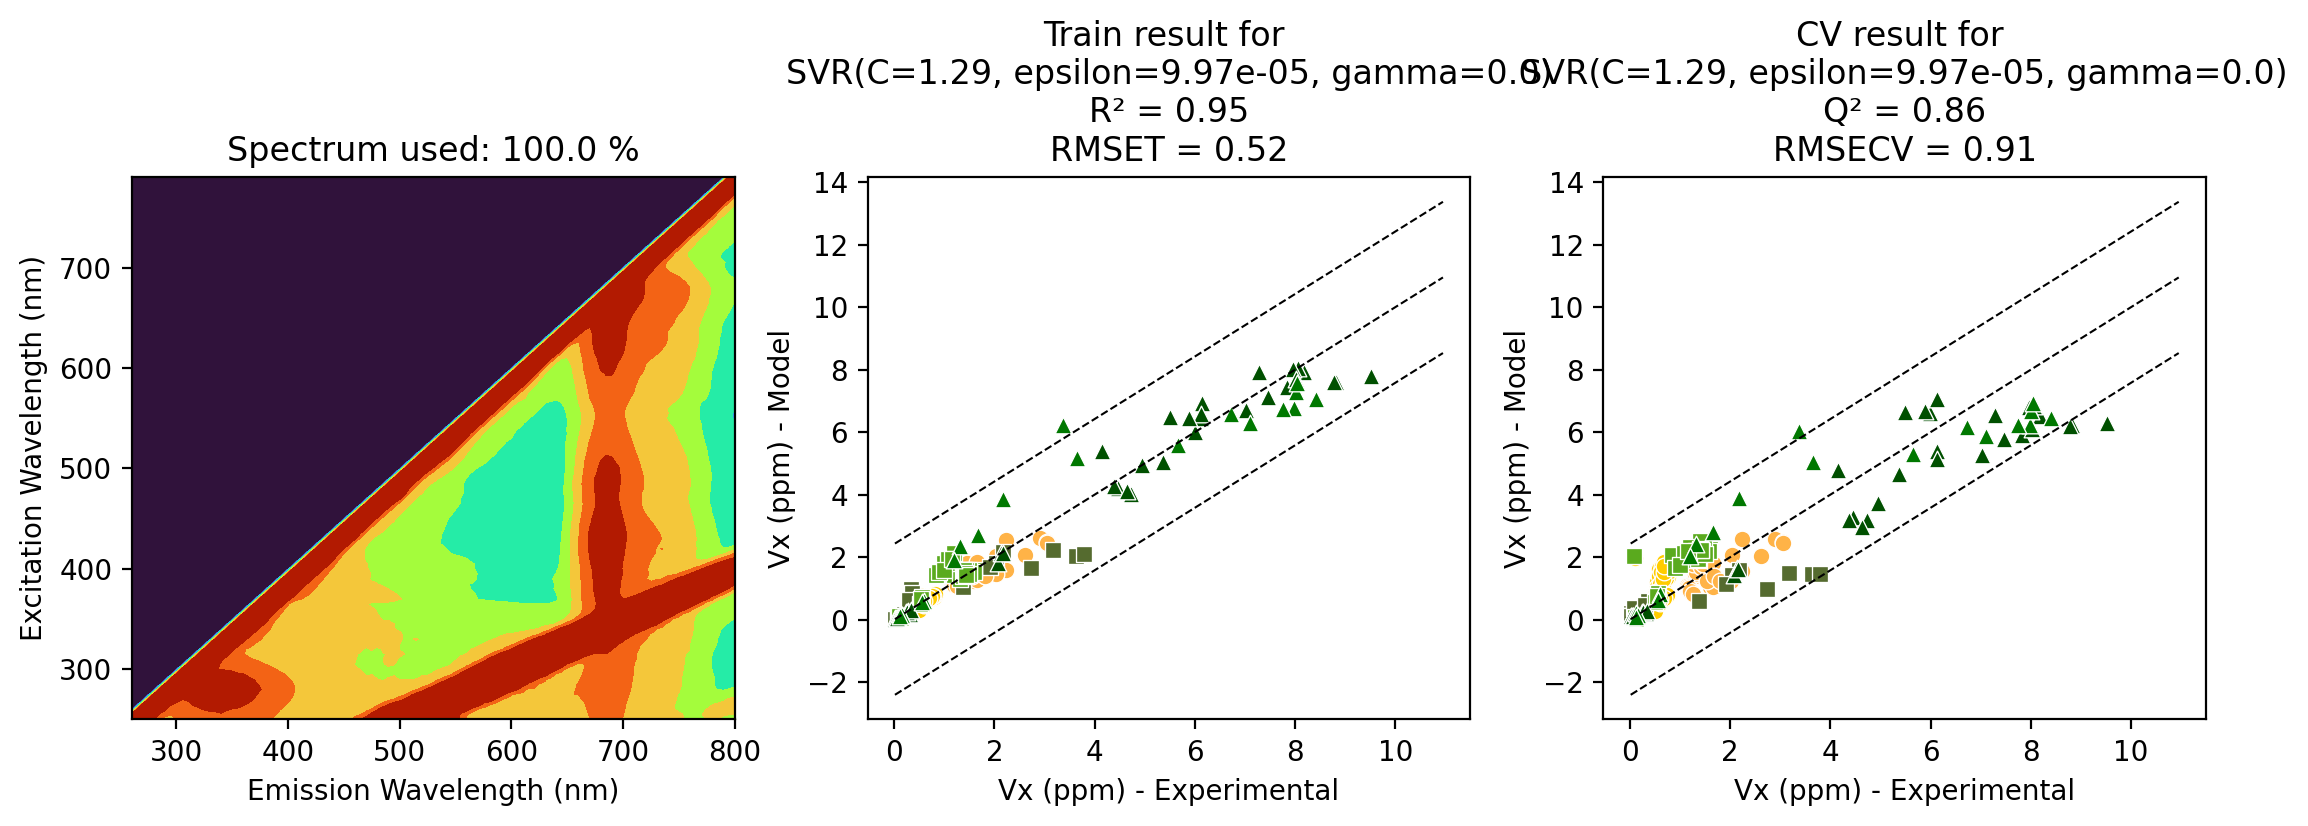

In [38]:
#%% - Plot results for Winner Pipeline

import numpy as np

# Choose colors and markers for accuracy plots

colors = [
    (255, 179, 71),   # Yellowish Orange
    (255, 204, 0),      # Yellow-Orange
    (85, 107, 47),    # Dark Olive Green (Brownish Green)
    (90, 170, 30),    # Olive Green
    (0, 80, 0),      # Dark Green
    (0, 120, 0),      # Forest Green
]

markers = ['o','o','s','s','^','^']

# Sample whose spectra is used for showing for spectral variable selection
sample2plot = 'NOAx2_03_20'

from special_plots import plot_bestmodel2
from accuracy import r2,rmse,r2_score,plotAccScatters_justtest
from accuracy import cross_val_predict


sampledata = y_train.reset_index().iloc[:,:IDCOLUMNS_COUNT]
y_predtrainCV = cross_val_predict(best_pipe, X_train, y_train.values.ravel(), 
                                  cv=group_kfold,
                                  groups=groups
                                  )
  
rmseCV = rmse(y_train, y_predtrainCV)
q2 = r2_score(y_train, y_predtrainCV)
print("Best cross-validation Q2:", np.round(q2,3))
print("Best cross-validation rmse:", np.round(rmseCV,3))


y_predtrainCV = pd.DataFrame(data=y_predtrainCV,
                             index=y_train.index,
                             columns=[output2predict+' - Model'])


plot_bestmodel2(best_pipe2,X_train.copy() ,y_train,group_kfold,groups,
                   sample2plot,output2predict,sampledata,spectroscopy,'Assay',
                   markers=markers, colors=colors,rgb_colors=True,
                   # randomCVfold=6
                   )

In [36]:
best_pipe


Pipeline(steps=[('Wave-selection',
                 waveRestrictor2(name='Moving-Window', window='All_1', window_dict={'All_1': ['EEP 250 / 260 nm', 'EEP 250 / 265 nm', 'EEP 250 / 270 nm', 'EEP 250 / 275 nm', 'EEP 250 / 280 nm', 'EEP 250 / 285 nm', 'EEP 250 / 290 nm', 'EEP 250 / 295 nm', 'EEP 250 / 300 nm', 'EEP 250 / 305 nm', 'EEP 250 / 310 nm', 'EEP 250 / 315 nm', 'EEP 250 / 320 nm', 'EEP 250 / 325 nm', 'EEP 250 / 330 nm', 'EEP 250 / 335 nm', 'E...660 nm', 'EEP 280 / 660 nm', 'EEP 285 / 660 nm', 'EEP 290 / 660 nm', 'EEP 295 / 660 nm', 'EEP 250 / 665 nm', 'EEP 255 / 665 nm', 'EEP 260 / 665 nm', 'EEP 265 / 665 nm', 'EEP 270 / 665 nm', 'EEP 275 / 665 nm', 'EEP 280 / 665 nm', 'EEP 285 / 665 nm', 'EEP 290 / 665 nm', 'EEP 295 / 665 nm']})),
                ('Pre-process', StandardScaler()),
                ('Algorithm',
                 SVR(C=np.float64(1.8976305196723557),
                     epsilon=np.float64(0.00035633356650064757)))])

In [37]:
best_pipe2

Pipeline(steps=[('Wave-selection',
                 waveRestrictor2(name='Moving-Window', window='All_1', window_dict={'All_1': ['EEP 250 / 260 nm', 'EEP 250 / 265 nm', 'EEP 250 / 270 nm', 'EEP 250 / 275 nm', 'EEP 250 / 280 nm', 'EEP 250 / 285 nm', 'EEP 250 / 290 nm', 'EEP 250 / 295 nm', 'EEP 250 / 300 nm', 'EEP 250 / 305 nm', 'EEP 250 / 310 nm', 'EEP 250 / 315 nm', 'EEP 250 / 320 nm', 'EEP 250 / 325 nm', 'EEP 250 / 330 nm', 'EEP 250 / 335 nm', 'E...', 'EEP 275 / 660 nm', 'EEP 280 / 660 nm', 'EEP 285 / 660 nm', 'EEP 290 / 660 nm', 'EEP 295 / 660 nm', 'EEP 250 / 665 nm', 'EEP 255 / 665 nm', 'EEP 260 / 665 nm', 'EEP 265 / 665 nm', 'EEP 270 / 665 nm', 'EEP 275 / 665 nm', 'EEP 280 / 665 nm', 'EEP 285 / 665 nm', 'EEP 290 / 665 nm', 'EEP 295 / 665 nm']})),
                ('Pre-process', StandardScaler()),
                ('Algorithm',
                 SVR(C=1.295, epsilon=9.97e-05,
                     gamma=np.float64(0.00010351037602337447)))])

Testing

RMSEP=  0.6948502170999467
R2 =  0.9375537404129205


C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


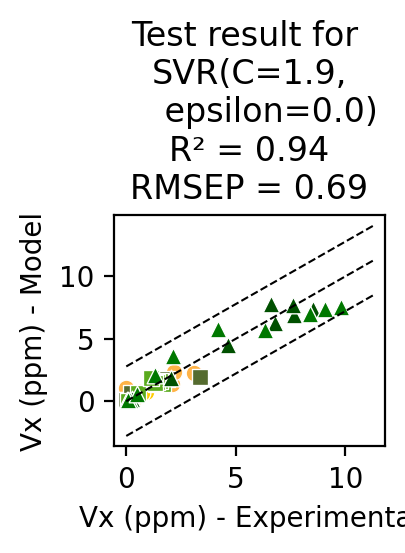

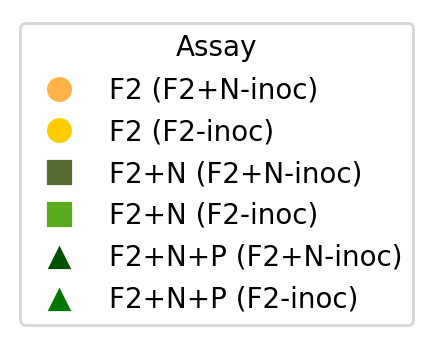

In [40]:
# 7.1. Predict the test set that was split out

# Choose same colors/markers as training set, as the assays are the same
colors = [
    (255, 179, 71),   # Yellowish Orange
    (255, 204, 0),      # Yellow-Orange
    (85, 107, 47),    # Dark Olive Green (Brownish Green)
    (90, 170, 30),    # Olive Green
    (0, 80, 0),      # Dark Green
    (0, 120, 0),      # Forest Green
]

markers = ['o','o','s','s','^','^']


y_pred = best_pipe2.predict(X_test)

# Compute accuracy metrics
rmseP = rmse(y_test, y_pred).iloc[0]
r2 = r2_score(y_test, y_pred)

print('RMSEP= ',rmseP)
print('R2 = ', r2)

# Plot accuracy
sampledata = y_test.reset_index().iloc[:,:IDCOLUMNS_COUNT]
y_pred = pd.DataFrame(data=y_pred,index=y_test.index,
                             columns=[output2predict+' - Model'])

import re

def clean_param_string(param_string, precision=2):
    def convert_np_number(match):
        value = match.group(2)
        num_type = match.group(1)
        if 'float' in num_type:
            return str(round(float(value), precision))
        else:
            return str(int(float(value)))  # handles int64, int32, etc.

    # Replace np.float64(...) and np.int64(...) etc. with rounded numbers
    cleaned = re.sub(r'np\.(float\d*|int\d*)\(([^)]+)\)', convert_np_number, str(param_string))

    # Optional: also round plain floats like gamma=0.2133654785111
    cleaned = re.sub(r'(?<=\=)(\d+\.\d+)', lambda m: str(round(float(m.group(1)), precision)), cleaned)

    return cleaned


model_ID = clean_param_string(str(best_pipe.named_steps['Algorithm']))

plotAccScatters_justtest(False,y_test,y_pred,output2predict,
                         model_ID,
                            r2,rmseP,sampledata,'Assay',True,"Test","Assay",
                            valcolor=colors,
                            valmarkers=markers,
                            rgb_colors=True,
                            )

RMSEP=  0.7820764417791178
R2 =  0.7842513162939112


C:\Users\pedro.brandao\Documents\Python env\virtual_env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


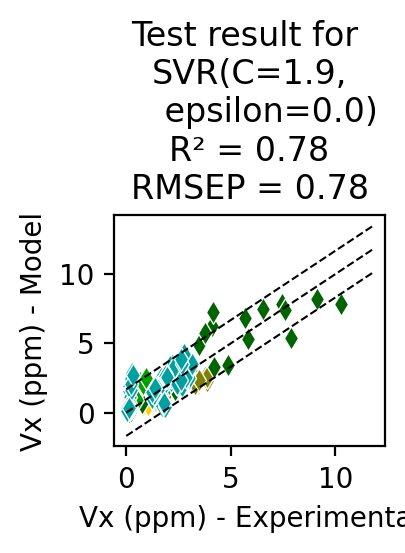

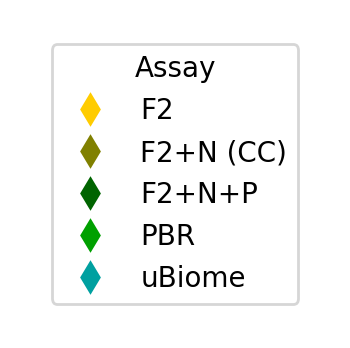

In [42]:
# 7.2. Predict an external test

# Load external data set
folder = 'NO Dataset/Test Set'

monitordata_2 = pd.read_pickle(folder + '/monitordata.pkl').set_index(sampleinfo)
fluorodata_2 = pd.read_pickle(folder + '/fluorodata.pkl').set_index(sampleinfo)
absdata_2 = pd.read_pickle(folder + '/absdata.pkl').set_index(sampleinfo)

df_2 = monitordata_2[[output2predict]].join(fluorodata_2).dropna()

from dataframe_handlers import filter_dataframe
df_2 = filter_dataframe(df_2, 
                        {'Assay_ID':['S2021']}, filter_out=True)

X_test2 = df_2[fluorowaves]
y_test2 = df_2[[output2predict]]

# Plot accuracy, with different colors/markers
markers = ['d','d','d','d','d']

colors = [
    (255, 204, 0),      # Yellow-Orange
    (128, 128, 0),    # Olive Green    
    (0, 100, 0),      # Dark Green
    (0, 160, 0),      # Forest Green  
    (0, 160, 160),      # Forest Green 
]

# Make the prediction using the test set fluorescence
y_pred2 = best_pipe.predict(X_test2)

# Compute accuracy metrics, comparing with test set standard data (HPLC)
rmseP2 = rmse(y_test2, y_pred2).iloc[0]
r2_2 = r2_score(y_test2, y_pred2)

print('RMSEP= ',rmseP2)
print('R2 = ', r2_2)


y_pred2 = pd.DataFrame(data=y_pred2,index=y_test2.index,
                             columns=[output2predict+' - Model'])

plotAccScatters_justtest(False,y_test2,y_pred2,output2predict,
                         model_ID,
                            r2_2,rmseP2,sampledata,'Assay',True,"Test","Assay",
                            valcolor=colors,
                            valmarkers=markers,
                            rgb_colors=True,
                            )
